In [26]:
# N-CryptoAsset Portfolio Analisys and Accounting. 
# 1. PCA source http://www.quantatrisk.com/tag/python/
# 2. K_means пока нет
# 3. Markowitz пока нет
#  
%matplotlib inline   
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from datetime import datetime
import json
from bs4 import BeautifulSoup
import requests
 
# define some custom colours

grey = .6, .6, .6
 
def timestamp2date(timestamp):
    # function converts a Unix timestamp into Gregorian date
    return datetime.fromtimestamp(int(timestamp)).strftime('%Y-%m-%d')
 
def date2timestamp(date):
    # function coverts Gregorian date in a given format to timestamp
    return datetime.strptime(date_today, '%Y-%m-%d').timestamp()
 
def fetchCryptoClose(fsym, tsym):
    # function fetches the close-price time-series from cryptocompare.com
    # it may ignore USDT coin (due to near-zero pricing)
    # daily sampled
    cols = ['date', 'timestamp', fsym]
    lst = ['time', 'open', 'high', 'low', 'close']
    timestamp_today = datetime.today().timestamp()
    curr_timestamp = timestamp_today
 
    for j in range(2):
        df = pd.DataFrame(columns=cols)
        url = "https://min-api.cryptocompare.com/data/histoday?fsym=" + fsym + \
              "&tsym=" + tsym + "&toTs=" + str(int(curr_timestamp)) + "&limit=2000"
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        dic = json.loads(soup.prettify())
        for i in range(1, 2001):
            tmp = []
            for e in enumerate(lst):
                x = e[0]
                y = dic['Data'][i][e[1]]
                if(x == 0):
                    tmp.append(str(timestamp2date(y)))
                tmp.append(y)
            if(np.sum(tmp[-4::]) > 0):  # remove for USDT
                tmp = np.array(tmp)
                tmp = tmp[[0,1,4]]  # filter solely for close prices
                df.loc[len(df)] = np.array(tmp)
        # ensure a correct date format
        df.index = pd.to_datetime(df.date, format="%Y-%m-%d")
        df.drop('date', axis=1, inplace=True)
        curr_timestamp = int(df.ix[0][0])
        if(j == 0):
            df0 = df.copy()
        else:
            data = pd.concat([df, df0], axis=0)
    data.drop("timestamp", axis=1, inplace=True)
 
    return data  # DataFrame

In [5]:
def loadAssets(fsym):
    #load assets 
    for e in enumerate(fsym):
        print(e[0], e[1])
        if(e[0] == 0):
            try:
                data = fetchCryptoClose(e[1], tsym)
            except:
                pass
        else:
            try:
                data = data.join(fetchCryptoClose(e[1], tsym))
            except:
                pass

    data = data.astype(float)  # ensure values to be floats
    return data

In [23]:
def pcaAssets(dfP):

    m = dfP.mean(axis=0)
    s = dfP.std(ddof=1, axis=0)
                
    print(s)

    # normalised time-series as an input for PCA
    dfPort = (dfP - m)/s

    c = np.cov(dfPort.values.T)     # covariance matrix
    co = np.corrcoef(dfP.values.T)  # correlation matrix

    tickers = list(dfP.columns)

    plt.figure(figsize=(8,8))
    plt.imshow(co, cmap="RdGy", interpolation="nearest")
    cb = plt.colorbar()
    cb.set_label("Correlation Matrix Coefficients")
    plt.title("Correlation Matrix", fontsize=14)
    plt.xticks(np.arange(len(tickers)), tickers, rotation=90)
    plt.yticks(np.arange(len(tickers)), tickers)

    # perform PCA
    w, v = np.linalg.eig(c)  

    ax = plt.figure(figsize=(8,8)).gca()
    plt.imshow(v, cmap="bwr", interpolation="nearest")
    cb = plt.colorbar()
    plt.yticks(np.arange(len(tickers)), tickers)
    plt.xlabel("PC Number")
    plt.title("PCA", fontsize=14)
    # force x-tickers to be displayed as integers (not floats)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [9]:
# N-Cryptocurrency Portfolio (tickers)
fsym = ['BTC', 'ETH', 'DASH', 'XMR', 'XRP', 'LTC', 'ETC', 'XEM', 'REP', 
        'MAID', 'ZEC', 'STEEM', 'GNT', 'FCT', 'ICN', 'DGD', 
        'WAVES', 'DCR', 'LSK', 'DOGE', 'PIVX']
# vs. 
tsym = 'USD'

data = loadAssets(fsym)
data = data.astype(float)  # ensure values to be floats
 
# save portfolio to a file (HDF5 file format)
# loading file just for example
store = pd.HDFStore('portfolio.h5')
store['data'] = data
store.close()
# read in your portfolio from a file
df = pd.read_hdf('portfolio.h5', 'data')
dfP = df[(df.index >= "2017-03-01") & (df.index <= "2017-03-31")]
dfP = dfP.dropna(axis=1, how='any')

0 BTC
1 ETH
2 DASH
3 XMR
4 XRP
5 LTC
6 ETC
7 XEM
8 REP
9 MAID
10 ZEC
11 STEEM
12 GNT
13 FCT
14 ICN
15 DGD
16 WAVES
17 DCR
18 LSK
19 DOGE
20 PIVX


In [13]:
store = pd.HDFStore('portfolio.h5')
store['data'] = data
store.close()

df = pd.read_hdf('portfolio.h5', 'data')
dfP = df[(df.index >= "2017-03-01") & (df.index <= "2017-03-31")]
dfP = dfP.dropna(axis=1, how='any')

                BTC      XRP   LTC   ETC   REP    ZEC    STEEM      GNT   FCT  \
date                                                                            
2017-03-01  1154.55  0.00525  3.75  1.22  4.28  36.87  0.09104  0.02090  2.75   
2017-03-02  1211.96  0.00531  3.78  1.33  4.92  35.00  0.08787  0.02008  2.81   
2017-03-03  1250.80  0.00592  3.94  1.32  5.63  37.71  0.08455  0.02155  2.95   
2017-03-04  1228.73  0.00620  3.91  1.39  5.27  35.00  0.08468  0.02246  2.91   
2017-03-05  1242.10  0.00601  3.90  1.35  5.27  38.83  0.08770  0.02103  2.98   

               ICN    DGD   WAVES   DCR      LSK      DOGE     PIVX  
date                                                                 
2017-03-01  0.2998   8.51  0.1736  1.90  0.09246  0.000198  0.03695  
2017-03-02  0.2404   8.87  0.1760  1.85  0.09405  0.000193  0.04196  
2017-03-03  0.2353  10.01  0.1817  2.02  0.10450  0.000194  0.04129  
2017-03-04  0.2784   9.83  0.1893  1.89  0.10410  0.000197  0.04056  
2017-03-05  

BTC      111.742765
XRP        0.001745
LTC        0.376665
ETC        0.386070
REP        1.605710
ZEC       11.514981
STEEM      0.035527
GNT        0.014276
FCT        0.369237
ICN        0.089498
DGD        2.788255
WAVES      0.055025
DCR        3.003079
LSK        0.069441
DOGE       0.000028
PIVX       0.227894
dtype: float64


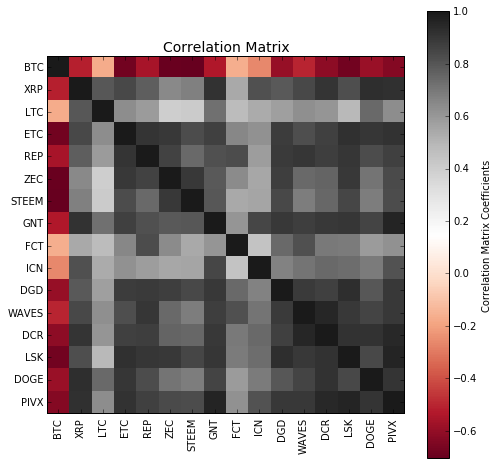

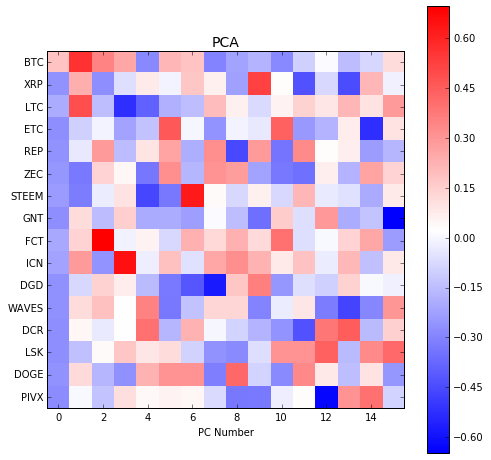

In [27]:
pcaAssets(dfP)